<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/NLP/Text_search_engine_movie_tfidf_doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to make a search engine on Movies Description

In this notebook, you will learn how to :

1. [Create a Doc2Vec model that represents words and documents into numerical vectors](#creating)

2. [Find words related to other words](#words)
3. [Find the document that has the closest meaning to a list of key words like in a search engine](#docs)

4. [Create a TF-IDF search engine](#tfidf)



<div class="alert alert-warning">
To run this notebook, you will need :
<ul>
<li>to run on **python 3.6.2**</li>
<li>to have **gensim** installed. Run '**pip install gensim**' in the python environment you are using for this notebook.</li>
<li>to have **langdetect** installed. Run '**pip install langdetect**' in the python environment you are using for this notebook.</li>
</ul>

</div>

We will start by importing what we need and downloading the files with the movies description.

The dataset comes from a kaggle dataset : https://www.kaggle.com/rounakbanik/the-movies-dataset/data

In [0]:
!pip install gensim
!pip install langdetect

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import Doc2Vec
from collections import namedtuple
import gensim.utils
from langdetect import detect
import re
import string

In [7]:
imdbdata=pd.read_csv('movies.csv')
data = np.array(imdbdata.overview)
titles=np.array(imdbdata.original_title)

imdbdata.head()

,overview,original_title
0,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,When siblings Judy and Peter discover an encha...,Jumanji
2,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,Just when George Banks has recovered from his ...,Father of the Bride Part II


## Text preprocessing

In order to build the doc2vec model we need to clean the data that we have. We will remove documents that are not strings, that are too short and that are not written in english.
Then, we will remove punctuation, and lowercase every word.
We will build the list **alldocs** that contains every documents cleaned.

In [0]:
SentimentDocument = namedtuple('SentimentDocument', 'words tags title original_number')
n=0
alldocs = []  # Will hold all docs in original order

regex = re.compile('[%s]' % re.escape(string.punctuation)) #to remove punctuation

for line_no, line in enumerate(data):
    if (type(line)==str):
        if (len(line)>150):
            if (detect(line) == 'en') :
                line = regex.sub('', line)
                tokens = gensim.utils.to_unicode(line).lower().split()
                words = tokens[0:]
                tags = [n]
                title = titles[line_no]
                alldocs.append(SentimentDocument(words, tags, title, line_no))
                n=n+1    

Some insights on the dataset :

Number of Documents :  34179
Mean length of documents :  65.90827701220047


Text(0, 0.5, 'Length of the description')

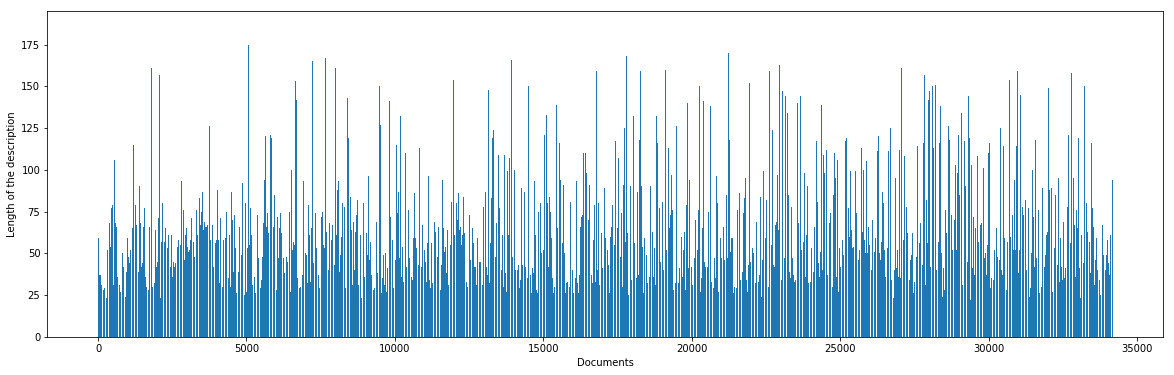

In [9]:
l = []
for doc in alldocs:
    l.append(len(doc.words))

print('Number of Documents : ', len(alldocs))
print('Mean length of documents : ', np.mean(l))

plt.figure (figsize=(20, 6))
plt.bar(range(0, len(l)), l)
plt.xlabel('Documents')
plt.ylabel('Length of the description')

In [10]:
# An example of how the list alldocs is build

index = 0
doc = alldocs[index]
print(doc, '\n')
print(data[doc.original_number])

SentimentDocument(words=['led', 'by', 'woody', 'andys', 'toys', 'live', 'happily', 'in', 'his', 'room', 'until', 'andys', 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'the', 'scene', 'afraid', 'of', 'losing', 'his', 'place', 'in', 'andys', 'heart', 'woody', 'plots', 'against', 'buzz', 'but', 'when', 'circumstances', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', 'the', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'their', 'differences'], tags=[0], title='Toy Story', original_number=0) 

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


## <a id="creating"></a> Creating and training the Doc2Vec model

We create the Distributed Memory model with a size of 300 ( that means that the vectors will be of size 300). The window size is 10. We do not take in account words that are seen less than 10 times in the entire corpus with the variable *min_count*. Setting the variable *dbow_words* to 1 means that we are also training to represents words with numerical vectors.

We then train our model over 100 epochs with a lerning rate of 0.01.

Full documentation can be found here :
<li> gensim : https://radimrehurek.com/gensim/ </li>
<li> Doc2Vec : https://radimrehurek.com/gensim/models/doc2vec.html </li>
<li> A great article introducing the concepts behind Doc2Vec : https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e </li>
<li> Detailed scientific paper : https://cs.stanford.edu/~quocle/paragraph_vector.pdf </li>


In [11]:
# PV-DM
model = Doc2Vec(dm=1, size=300,window=10,hs=0,min_count=10,dbow_words=1,sample=1e-5)

# build the vocabulary 
model.build_vocab(alldocs)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [0]:
model.train(alldocs, total_examples=model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)

We can save and load models with the lines below.

In [13]:
model.save("model")
#Doc2Vec.load("model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## <a id="words"></a>Evaluating words embedding

We will evaluate our model with some examples by showing the closest words to the words love, war and space.

As the process of training a neural network does not always come to the same model, if the results do not make sense, you might consider creating the model and training it again.



In [14]:
model.wv.most_similar_cosmul(positive = ["love"])

[('falls', 0.8456960320472717),
 ('falling', 0.8185344338417053),
 ('fall', 0.8124783039093018),
 ('madly', 0.8113616108894348),
 ('triangle', 0.7776875495910645),
 ('unrequited', 0.7549318075180054),
 ('fallen', 0.7529939413070679),
 ('heartbreak', 0.7453389167785645),
 ('loves', 0.7438414692878723),
 ('happiness', 0.7409876585006714)]

In [15]:
model.wv.most_similar_cosmul(positive = ["war"])

[('ii', 0.9141027331352234),
 ('civil', 0.8760365843772888),
 ('frontline', 0.8291715979576111),
 ('soldier', 0.8249968886375427),
 ('trenches', 0.8247454166412354),
 ('vietnam', 0.8145373463630676),
 ('ww', 0.81317138671875),
 ('gis', 0.812199592590332),
 ('soldiers', 0.8023731112480164),
 ('wartime', 0.7957614660263062)]

In [16]:
model.wv.most_similar_cosmul(positive = ["space"])

[('astronaut', 0.8965858221054077),
 ('mars', 0.8906508684158325),
 ('planet', 0.8886788487434387),
 ('astronauts', 0.8814858198165894),
 ('asteroid', 0.8767796754837036),
 ('outer', 0.8745329976081848),
 ('earth', 0.8705009818077087),
 ('nasa', 0.8696829676628113),
 ('spaceship', 0.869199275970459),
 ('spacecraft', 0.8598333597183228)]

The cell below show that the relationship of gender is understood by the model as we almost have the equation ** man - woman = king - queen**

In [17]:
model.wv.most_similar_cosmul(negative = ["man"], positive = ["king","woman"])

[('queen', 0.9082275032997131),
 ('crowned', 0.8749703764915466),
 ('princess', 0.8695081472396851),
 ('palace', 0.8532910346984863),
 ('governess', 0.8489845991134644),
 ('prince', 0.8458099365234375),
 ('dartagnan', 0.8364710807800293),
 ('empress', 0.8335840106010437),
 ('athos', 0.8330180644989014),
 ('throne', 0.8274832963943481)]

The results on the word embeddings are satisfying as we have coherent outputs.

## <a id="docs"></a>Evaluating documents embedding

We will evaluate our model of documents embedding with some examples by showing the closest documents to key words ( here called tokens). We expect the documents to have similar meanings than the key words. In this way, the model act as a search engine.

In [18]:
# Closest document to the word "war"

tokens = "war"

new_vector = model.infer_vector(tokens.split() ,alpha=0.001 ,steps = 5)
tagsim = model.docvecs.most_similar([new_vector])[0]

docsim = alldocs[tagsim[0] ]

print("Document : ", data[docsim.original_number], "\n")
print("Title : ", docsim.title)
print("Distance : ", tagsim[1])

Document :  A young boy and his dog, who happens to have a genius-level IQ, spring into action when their time-travel machine is stolen and moments in history begin to be changed. 

Titre :  Mr. Peabody & Sherman
Distance :  0.1758492887020111


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


We show the closest document to the key words, the farest document and a document in the middle.

In [19]:
# Closest document to the word "love"

tokens = "love"

new_vector = model.infer_vector(tokens.split() ,alpha=0.001 ,steps = 5)
sims = model.docvecs.most_similar([new_vector], topn=model.docvecs.count) # get *all* similar documents

print("Most : " , data[alldocs[sims[0][0]].original_number], "\n") 
print("Median : " , data[alldocs[sims[17000][0]].original_number], "\n")
print("Least : " , data[alldocs[sims[-1][0]].original_number])

Most :  An evil Duke attempts to kill and collect the blood of a royal family of European vampires in order to become all powerful. The only surviving member of the family travels to Hong Kong, only to complicate his struggle by falling in love with a mortal girl who just happens to have a vampire hunter for a brother. 

Median :  Lucien Bourrache, a good looking non-commissioned officer at the Spahis, is used to charm many women. He met Madeleine Courtois at Cannes. She is beautiful and lives in luxury. He lends her a large amount of money, which she loses gambling. Then she drops him. But Lucien is now in love, and once demobilized, he goes to Paris to find her again. But he's not so sexy without his uniform, and Madeleine and him do not belong to the same milieu. 

Least :  Mary Smith decides after a lifetime of being a shut-in to do something wild while her father is out campaigning for the presidency, so she takes off for the family's home in West Palm Beach and inadvertently beco

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In this example, in terms of reviewer tone, movie genre, etc... the MOST cosine-similar documents seem more like the key words than the MEDIAN or LEAST

In [20]:
doc = np.random.randint(model.docvecs.count)

sims = model.docvecs.most_similar(doc, topn=model.docvecs.count) # get *all* similar documents

print("Target : ", data[alldocs[doc] .original_number], "\n" )
print("Most : " , data[alldocs[sims[0][0]].original_number], "\n")
print("Median : " , data[alldocs[sims[34000][0]].original_number], "\n")
print("Least : " , data[alldocs[sims[-1][0]].original_number])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Target :  Banku, his mother, Anjali Sharma and father move in to their new house -- the Nath villa, unaware of the fact that the house is inhabited by a ghost. It is learnt the ghost is not too happy with his new housemates. But what the ghost is not prepared for is his unlikely friendship with Banku. Now Banku must uncover the reason why his ghostly friend is stuck and help him to attain salvation. 

Most :  Four friends go into a haunted mansion on a whim but they do not realize that they have returned home with an evil spirit, from which escape might be impossible. 

Median :  In 20 years, he's directed more films than Martin Scorsese, He's produced more profitable movies than Jerry Bruckheimer, And he's infuriated more actors than Alfred Hitchcock. The ultimate B Movie Documentary, focusing on B Movie Giant Jim Wynorski (and B Movie Celebration Mentor) and his attempt to make a feature film in 3 days. He's directed seventy feature films, but he's never made one... in THREE DAYS. Ji

Usually the MOST cosine-similar documents usually seem more like the TARGET than the MEDIAN or LEAST

 ## Pre-trained word embeddings
 
 It is possible to use pre-trained word embeddings for your model. Indeed, there is a word2vec model available here (https://code.google.com/archive/p/word2vec). This model is trained by google but might not be well suited for the problem you want to solve. 

In [0]:
# PV-DBOW (with negative sampling)
model_pre_trained = Doc2Vec(dm=0,size=300, window=15,hs=0,negative=5,min_count=10,dbow_words=1,sample=1e-5)

# build the vocabulary 
model_pre_trained.build_vocab(alldocs)

# use pre-trained word vectors from google
model_pre_trained.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [0]:
model_pre_trained.train(alldocs, total_examples=model.corpus_count, epochs=100)

## <a id="tfidf"></a>Creating the TF-IDF model

We create the TF-IDF model from the list alldocs with the module TfidfModel from gensim.


Full documentation can be found here :
<li> gensim : https://radimrehurek.com/gensim/ </li>
<li> Tf-Idf : https://radimrehurek.com/gensim/models/tfidfmodel.html </li>

In [0]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim import similarities 

dct = Dictionary(doc.words for doc in alldocs)  # fit dictionary
corpus = [dct.doc2bow(line.words) for line in alldocs]  # convert dataset to BoW format
model_tfidf = TfidfModel(corpus)  # fit model

In [24]:
# for example 
 
index = 0
print("Document ",index, " : ", data[alldocs[index].original_number] ) 
print("Bag of words representation of document ", index, " : ", corpus[index])

Document  0  :  Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
Bag of words representation of document  0  :  [(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3)]


## Creating Similarity matrix between a list of key words and all the documents

We create a matrix similarity thet represents the similarity between the list of key words and the documents.

In [25]:
#Create similarity matrix between doc and tokens
tokens = "love".split()
index = similarities.MatrixSimilarity([dct.doc2bow(tokens)],num_features=len(dct))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


We just use the document with the higher score of similarity.

In [26]:
similarity=np.zeros((len(alldocs)))
maxsim = 0
for id, doc in enumerate(alldocs):
    similarity[id] = index[dct.doc2bow(doc.words)]
    
docsim= alldocs[np.argmax(similarity)] 
print(data[docsim.original_number])
print(tagsim)
print(docsim.title)

Out of Love encapsulates the sweltering and devastating dynamics of love in the turbulent relationship between Varya and Nikolai, where genuine love and hope contend with destruction and despair.
(17943, 0.1758492887020111)
Out of Love


The output is coherent with the input as there is the word **love** 3 times in the document.

# Conclusion 

There are a lot of differences between the Doc2Vec search engine and the TF-IDF search engine. The TF-IDF model look only for the words listed in the key words that matches with the words in the document. This model is performing only if you look for documents that matches exactly the list of key words. But this model do not take into account the meaning of the words and the semantic proximity that can exist between 2 words. That is what is trying to achieve the Doc2Vec model. The goal is to create a model that represents meaning similarity between words and documents. The downside is that the model is more complex to create and depends on the data that is given and the tuning of hyper-parameters.